<a href="https://colab.research.google.com/github/MatthewYancey/16-9GAN/blob/master/src/model_preview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Preview
This notebook is for reviewing batches of images through a saved model

## Imports and Parameters

In [1]:
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# network parameters
BATCH_SIZE = 5
DATASET_SIZE = 100000
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.0002

# image
IMG_WIDTH = 455
# IMG_WIDTH = 256
IMG_HEIGHT = 256
SINGLE_SIDE = 57
# SINGLE_SIDE = 32

# directories
ZIP_PATH_TRAIN = '/content/gdrive/My Drive/16:9GAN/data_out/train.zip'
IMG_DIR_TRAIN = '/content/frames/train/'
ZIP_PATH_VAL = '/content/gdrive/My Drive/16:9GAN/data_out/validate.zip'
IMG_DIR_VAL = '/content/frames/validate/'
ZIP_PATH_TEST = '/content/gdrive/My Drive/16:9GAN/data_out/test.zip'
IMG_DIR_TEST = '/content/frames/test/'
LOG_DIR = '/content/gdrive/My Drive/16:9GAN/data_out/logs/model_001/'

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [3]:
# unzips images
shutil.unpack_archive(ZIP_PATH_TRAIN, IMG_DIR_TRAIN, 'zip')
shutil.unpack_archive(ZIP_PATH_VAL, IMG_DIR_VAL, 'zip')
shutil.unpack_archive(ZIP_PATH_TEST, IMG_DIR_TEST, 'zip')

In [4]:
# sets what device to run on
device = torch.device("cpu")
print(f'Device: {device}')

Device: cpu


## Helper Functions

### Apply Mask

In [5]:
# helper function for apply the mask for cutting the frame to 4:3
def apply_mask(img_batch):
    if len(img_batch.shape) > 3:
        img_batch[:, :, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        img_batch[:, :, :, :SINGLE_SIDE] = -1
    else:
        img_batch[:, :, (IMG_WIDTH - SINGLE_SIDE):] = -1
        img_batch[:, :, :SINGLE_SIDE] = -1
    
    return img_batch

### Apply Padding

In [6]:
# adds -1 padding to the sides of images that are in 4:3 aspect ratio
def apply_padding(img):
    padding = torch.zeros([3, IMG_HEIGHT, SINGLE_SIDE])
    padding = padding.new_full((3, IMG_HEIGHT, SINGLE_SIDE), -1)
    img_cat = torch.cat((padding, image, padding), 2)

    return img_cat

### Apply Composite

In [7]:
def apply_comp(img, img_gen):
    if len(img.shape) > 3:
        comp_img = torch.cat((img_gen[:, :, :, :SINGLE_SIDE], 
                            img[:, :, :, SINGLE_SIDE:(IMG_WIDTH-SINGLE_SIDE)], 
                            img_gen[:, :, :, (IMG_WIDTH-SINGLE_SIDE):]), 3)
    else:
        comp_img = torch.cat((img_gen[:, :, :SINGLE_SIDE], 
                    img[:, :, SINGLE_SIDE:(IMG_WIDTH-SINGLE_SIDE)], 
                    img_gen[:, :, (IMG_WIDTH-SINGLE_SIDE):]), 2)

    return comp_img

### Image Scaling

In [8]:
# helper function for converting images to a normal range
def img_scale(img_tensor, plot=False):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span

    # tensorboard and matplotlib take images in different formats
    if plot:
        img_tensor = img_tensor.transpose(0, 2)
        img_tensor = torch.rot90(img_tensor, -1) # fixes a rotation issue

    return img_tensor

## Data Loaders

In [9]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_list[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

### Training Data

In [10]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TRAIN + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')
img_list = img_list[:DATASET_SIZE]

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_train.dataset)}')

Number of images: 114808
Size of dataset: 100000


### Validation Data

In [11]:
# gets the list of images
img_list = glob.glob(IMG_DIR_VAL + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_val = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_val.dataset)}')

Number of images: 36734
Size of dataset: 36734


### Test Data

In [12]:
# gets the list of images
img_list = glob.glob(IMG_DIR_TEST + '*')
img_list.sort()
print(f'Number of images: {len(img_list)}')

# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    # transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print(f'Size of dataset: {len(dataloader_test.dataset)}')

Number of images: 2210
Size of dataset: 2210


## Networks

### Generartor

In [13]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.dilconv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.dilconv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.dilconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.dilconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv10 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.conv11 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.batch_norm3 = nn.BatchNorm2d(3)
        self.batch_norm32 = nn.BatchNorm2d(32)
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, img):
        # encoding
        x = self.conv1(img)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_norm128(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # dilation
        x = self.dilconv1(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv2(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv3(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        x = self.dilconv4(x)
        x = self.batch_norm256(x)
        x = self.relu(x)        

        # more encoding
        x = self.conv7(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        x = self.conv8(x)
        x = self.batch_norm256(x)
        x = self.relu(x)

        # decoding
        x = self.deconv1(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.conv9(x)
        x = self.batch_norm128(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.batch_norm64(x)
        x = self.relu(x)

        x = self.conv10(x)
        x = self.batch_norm32(x)
        x = self.relu(x)

        # output
        x = self.conv11(x)
        x = self.tanh(x)

        # creates the local output and global output that is combined with the orginal image
        gen_output_local = x[:, :, :, (IMG_WIDTH - SINGLE_SIDE):]
        global_gen_output = x

        return (gen_output_local, x)

### Initialize the Networks

### Loss Function and Optimizer

### Loads Checkpoints

In [14]:
gen = Generator(N_GPU).to(device)

# loads the model weights
saved_checkpoint = torch.load(LOG_DIR + 'checkpoint.pt')
gen.load_state_dict(saved_checkpoint['gen_state'])
print('Checkpoint Loaded')

Checkpoint Loaded


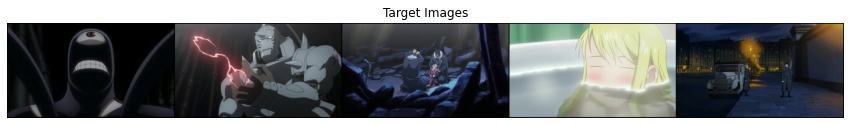

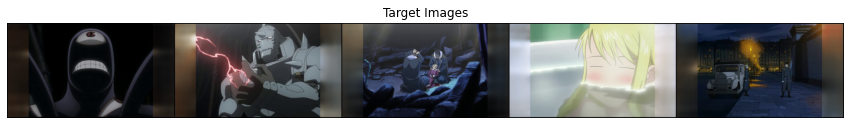

In [21]:
batch = next(iter(dataloader_train))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

_, batch_out = gen(apply_mask(batch))
batch_out = apply_comp(batch, batch_out)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_out.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

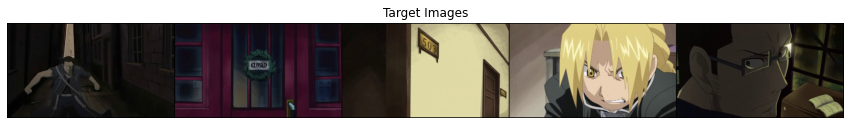

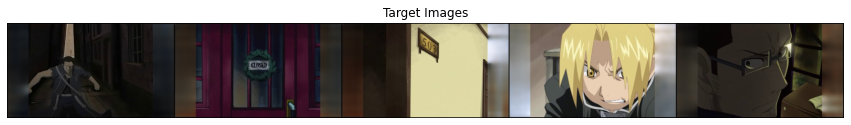

In [22]:
batch = next(iter(dataloader_val))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

_, batch_out = gen(apply_mask(batch))
batch_out = apply_comp(batch, batch_out)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch_out.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))